# scRNA-seq marker feature significance calculation

Here we will use 10X PBMCs scRNA-seq dataset as an example to illustrate how SIMBA performs scRNA-seq marker feature significance calculation. Other analysis steps can be done as the same in "scRNA-seq analysis" tutorial.

In [2]:
import os
import simba as si
si.__version__

/srv/local/jayoung/conda/envs/jy_simba_copy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [3]:
workdir = 'result_simba_rnaseq'
si.settings.set_workdir(workdir)

Saving results in: result_simba_rnaseq


In [4]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [5]:
# make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_3442/3704955539.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### load example data

In [6]:
adata_CG = si.datasets.rna_10xpmbc3k()

In [7]:
adata_CG

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype'
    var: 'gene_ids'

### preprocessing

In [8]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
2700 cells, 32738 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2700 cells, 13714 genes


In [9]:
si.pp.cal_qc_rna(adata_CG)

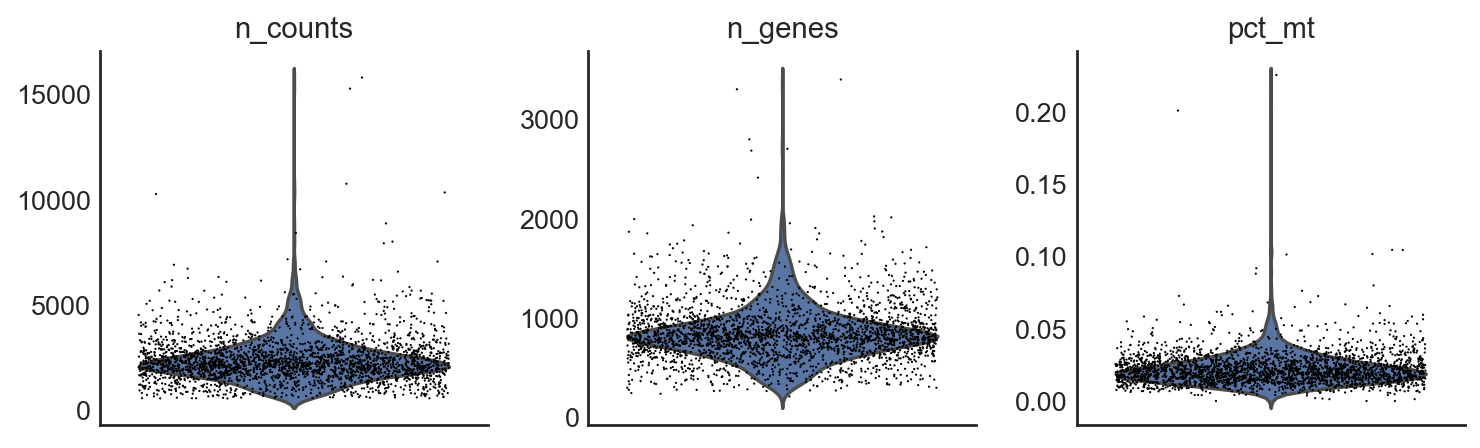

In [10]:
si.pl.violin(adata_CG,list_obs=['n_counts','n_genes','pct_mt'])

Filter out cells if needed:

```python
si.pp.filter_cells_rna(adata,min_n_genes=100)
```

In [11]:
si.pp.normalize(adata_CG,method='lib_size')

In [12]:
si.pp.log_transform(adata_CG)

Optionally, variable gene selection step can be also performed. 

```python
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)
si.pl.variable_genes(adata_CG,show_texts=True)
```

This will speed up the training procedure as only variable genes are encoded into the graph. But we won't obtain the embeddings of non-variable genes.

### discretize RNA expression

In [13]:
si.tl.discretize(adata_CG,n_bins=5)

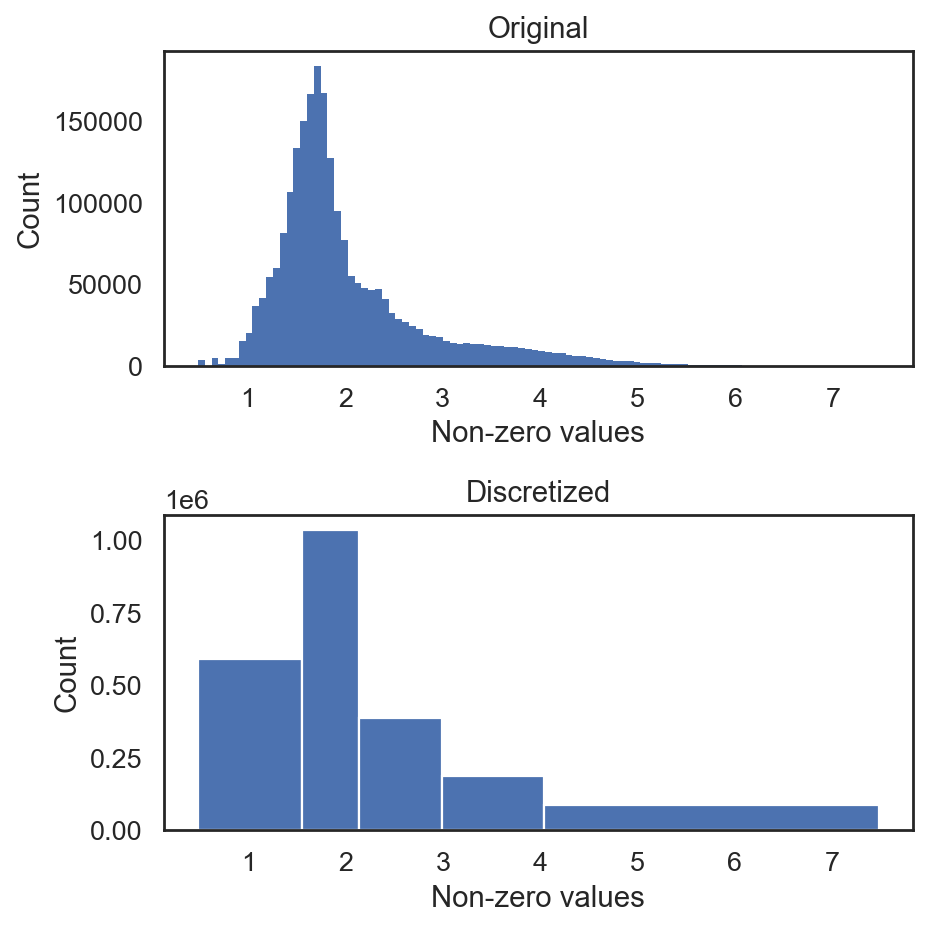

In [14]:
si.pl.discretize(adata_CG,kde=False)

### generate graph

In [15]:
%%time
si.tl.gen_graph(list_CG=[adata_CG],
                copy=False,
                layer='simba',
                use_highly_variable=False,
                dirname='graph_20',
                get_marker_significance=True,
                fold_null_nodes=20.0)

relation0: source: C, destination: G
#edges: 590134
relation1: source: C, destination: G
#edges: 1034817
relation2: source: C, destination: G
#edges: 384939
relation3: source: C, destination: G
#edges: 185485
relation4: source: C, destination: G
#edges: 87601
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_rnaseq/pbg/graph_20" ...
Finished.
input graph: (2700, 13714)
relation0: source: C, destination: G
#edges: 590134
relation1: source: nG, destination: C
#edges: 11802680
relation2: source: C, destination: G
#edges: 1034817
relation3: source: nG, destination: C
#edges: 20696340
relation4: source: C, destination: G
#edges: 384939
relation5: source: nG, destination: C
#edges: 7698780
relation6: source: C, destination: G
#edges: 185485
relation7: source: nG, destination: C
#edges: 3709700
relation8: source: C, destination: G
#edges: 87601
relation9: source: nG, destination: C
#edges: 1752020
Total number of edges: 47942496
Writing graph file "pbg_graph.t

### PBG training

Before PBG training, let's take a look at the parameters:

In [16]:
si.settings.pbg_params

{'entity_path': 'result_simba_rnaseq/pbg/graph_20/input/entity',
 'edge_paths': ['result_simba_rnaseq/pbg/graph_20/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'G': {'num_partitions': 1},
  'nG': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.0,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_ba

In [17]:
si.settings.graph_stats

{'graph_20': {'relation0': {'source': 'C',
   'destination': 'G',
   'n_edges': 590134},
  'relation1': {'source': 'C', 'destination': 'G', 'n_edges': 1034817},
  'relation2': {'source': 'C', 'destination': 'G', 'n_edges': 384939},
  'relation3': {'source': 'C', 'destination': 'G', 'n_edges': 185485},
  'relation4': {'source': 'C', 'destination': 'G', 'n_edges': 87601},
  'n_edges': 2282976,
  'entities': {'C': {'num_partitions': 1},
   'G': {'num_partitions': 1},
   'nG': {'num_partitions': 1}},
  'relations': [{'name': 'r0',
    'lhs': 'C',
    'rhs': 'G',
    'operator': 'none',
    'weight': 1.0},
   {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
   {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
   {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
   {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}]},
 'graph_20_with_sig': {'relation0': {'source': 'C',
   'destination': 'G',
  

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change `wd_interval`:

In [18]:
%%time
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.015521 
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 12 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model_wdfix', get_marker_significance=True)

Auto-estimated weight decay is 1.552147E-02
`.settings.pbg_params['wd']` has been updated to 1.552147E-02
Converting input data ...
[2022-12-04 17:21:34.137697] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2022-12-04 17:21:34.138406] These files are in: result_simba_rnaseq/pbg/graph_20/input/entity, result_simba_rnaseq/pbg/graph_20/input/edge
Starting training ...
Finished
Converting input data ...
[2022-12-04 17:21:35.456212] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2022-12-04 17:21:35.456854] These files are in: result_simba_rnaseq/pbg/graph_20_with_sig/input/entity, result_simba_rnaseq/pbg/graph_20_with_sig/input/edge
Starting training ...
Finished
CPU times: user 280 ms, sys: 25.3 ms, total: 305 ms
Wall time: 2.29 s


> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different pathss
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./result_simba_rnaseq/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./result_simba_rnaseq/pbg/graph0/model/')
```

plotting training metrics to make sure the model is not overfitting

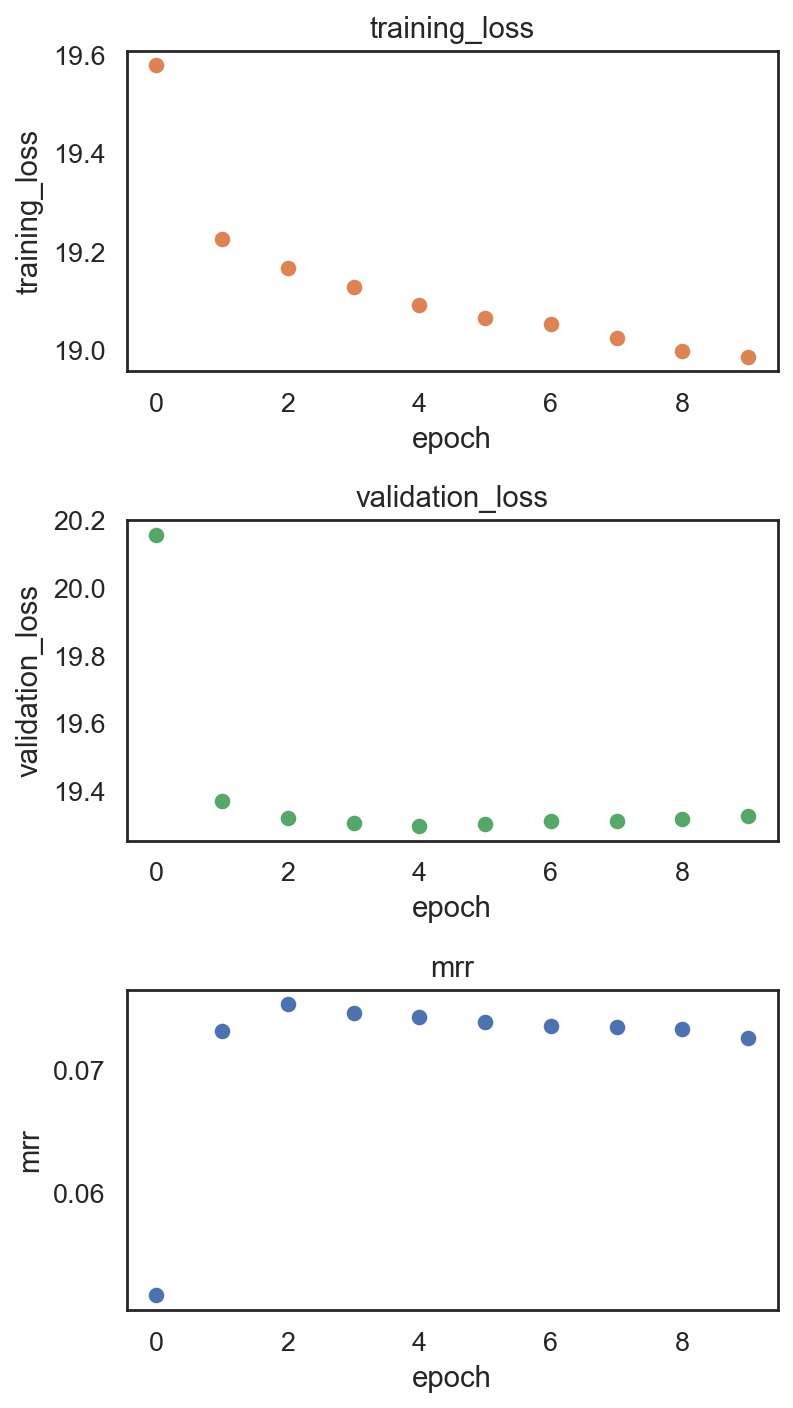

In [19]:
si.pl.pbg_metrics(fig_ncol=1)

### post-training analysis

In [20]:
dict_adata = si.read_embedding(get_marker_significance=True)

Null feature nodes for entity C not embedded.


In [21]:
dict_adata

{'C': AnnData object with n_obs × n_vars = 2700 × 50,
 'G': AnnData object with n_obs × n_vars = 13714 × 50,
 'nG': AnnData object with n_obs × n_vars = 274280 × 50}

In [22]:
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes
adata_nG = dict_adata['nG'] # embeddings for null genes

In [23]:
adata_C

AnnData object with n_obs × n_vars = 2700 × 50

In [24]:
adata_G

AnnData object with n_obs × n_vars = 13714 × 50

In [25]:
adata_nG


AnnData object with n_obs × n_vars = 274280 × 50

SIMBA metrics

In [26]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [27]:
%%time
adata_cmp = si.tl.compare_entities(adata_ref=adata_C, adata_query=adata_G, adata_query_null=adata_nG,)

CPU times: user 3min 24s, sys: 29.5 s, total: 3min 54s
Wall time: 3min 54s


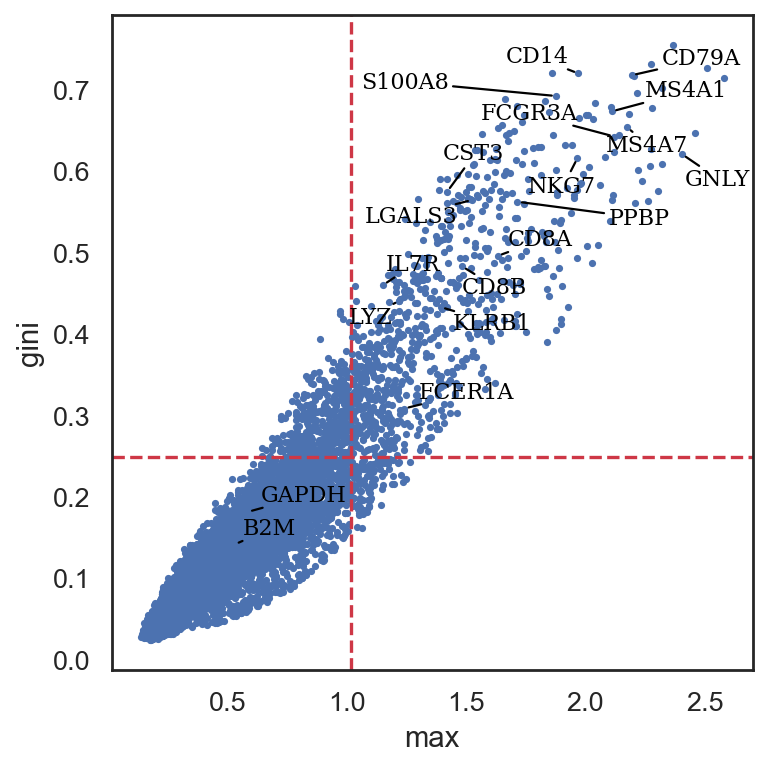

In [28]:
# B-H FDR
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_fdr=0.1,
                     save_fig=False)

In [29]:
# B-H FDR
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_fdr=0.1,
                     save_fig=True,
                     fig_name='entity_metrics_mg_fdr0.1.pdf',
                     rasterized=True)

In [30]:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='std',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_fdr=0.1,
                     save_fig=True,
                     fig_name='entity_metrics_ms_fdr0.1.pdf',
                     rasterized=True)


In [31]:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='entropy',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_fdr=0.1,
                     save_fig=True,
                     fig_name='entity_metrics_me_fdr0.1.pdf',
                     rasterized=True)


In [32]:
si.pl.entity_metrics(adata_cmp,
                     x='std',
                     y='entropy',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_fdr=0.1,
                     save_fig=True,
                     fig_name='entity_metrics_se_fdr0.1.pdf',
                     rasterized=True)


You can also visualize based on p-value thresholds.


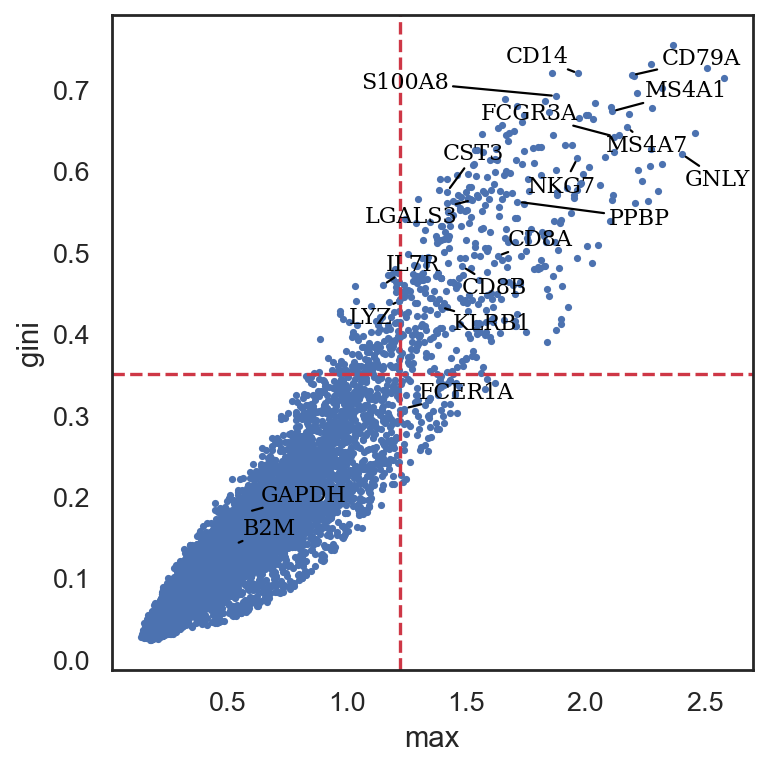

In [33]:
#FWER 0.05
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_p=0.05/adata_cmp.shape[1])

### save results

In [32]:
adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_nG.write(os.path.join(workdir, 'adata_nG.h5ad'))
adata_cmp.write(os.path.join(workdir, 'adata_cmp.h5ad'))